# Cat code
Gengyan Zhang, September 3 2016  
This notebook simulates some of the results in the following papers:
## References
1. [Vlastakis B, Kirchmair G, Leghtas Z, Nigg SE, Frunzio L, Girvin SM, et al. Deterministically Encoding Quantum Information Using 100-Photon Schrodinger Cat States. Science **342**, 607–610 (2013).](http://www.sciencemag.org/cgi/doi/10.1126/science.1243289)  
2. [Sun L, Petrenko A, Leghtas Z, Vlastakis B, Kirchmair G, Sliwa KM, et al. Tracking photon jumps with repeated quantum non-demolition parity measurements. Nature **511**, 444–448 (2014).](http://www.nature.com/doifinder/10.1038/nature13436)  
3. [Ofek N, Petrenko A, Heeres R, Reinhold P, Leghtas Z, Vlastakis B, et al. Extending the lifetime of a quantum bit with error correction in superconducting circuits. Nature **536**, 441–445 (2016).](http://www.nature.com/doifinder/10.1038/nature18949)

For simplicity, we omit the readout cavity in the following simulation and directly calculate the expectation value for desired operators for readout.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from IPython.display import display, Markdown
plt.rc('font', size=16)

## Parameters and operators

In [2]:
# Parameters
Nmax = 50
omegaQ = 6.3e9*2*np.pi
gammaQ = 1/35e-6
omegaS = 8.3e9*2*np.pi
kappaS = 1/250e-6
chiQS = 2e6*2*np.pi
# Operators
a = qt.tensor(qt.destroy(Nmax), qt.qeye(2))
adag = a.dag()
sx = qt.tensor(qt.qeye(Nmax), qt.sigmax())
sy = qt.tensor(qt.qeye(Nmax), qt.sigmay())
sz = qt.tensor(qt.qeye(Nmax), qt.sigmaz())
sm = qt.tensor(qt.qeye(Nmax), qt.sigmam())
# Hamiltonian H = -chi*adag*a*|e><e|
H0 = -chiQS*qt.tensor(qt.create(Nmax)*qt.destroy(Nmax),
                      qt.basis(2, 0)*qt.basis(2, 0).dag())

## Basic qubit and cavity operations

In [3]:
def gaussian(t, args):
    # Gaussian pulse shape
    sigma = args['sigma']
    return np.exp(-((t-4*sigma)/sigma)**2/2)


def applyGaus(psi0, amp, sigma):
    # Apply gaussian qubit drive pulse
    # psi0: initial state, amp: drive amplitude, sigma: pulse width
    # Return: final state
    args = {'sigma': sigma}
    tlist = np.linspace(0, 8*sigma, 201)
    result = qt.mesolve(H=[H0, [amp*sy, gaussian]], rho0=psi0, tlist=tlist,
                        c_ops=[np.sqrt(kappaS)*a, np.sqrt(gammaQ)*sm],
                        e_ops=[], args=args)
    return result.states[-1]


def applyRect(psi0, amp, duration):
    # Apply rectangular qubit drive pulse
    # psi0: initial state, amp: drive amplitude, duration: pulse duration
    # Return: final state
    tlist = np.linspace(0, duration, 201)
    result = qt.mesolve(H=H0-amp*sy, rho0=psi0, tlist=tlist,
                        c_ops=[np.sqrt(kappaS)*a, np.sqrt(gammaQ)*sm],
                        e_ops=[], args={})
    return result.states[-1]


def driveCavity(psi0, amp, duration):
    # Apply rectangular cavity drive pulse
    # psi0: initial state, amp: drive amplitude, duration: pulse duration
    # Return: final state
    tlist = np.linspace(0, duration, 201)
    H = H0 - (a+adag)*float(np.imag(amp)) - 1j*(a-adag)*float(np.real(amp))
    result = qt.mesolve(H=H, rho0=psi0, tlist=tlist,
                        c_ops=[np.sqrt(kappaS)*a, np.sqrt(gammaQ)*sm],
                        e_ops=[], args={})
    return result.states[-1]


def evolve(psi0, duration):
    # Evolve qubit-cavity system under dispersive Hamiltonian
    # psi0: initial state, duration: evolution time
    # Return: final state    
    tlist = np.linspace(0, duration, 201)
    result = qt.mesolve(H=H0, rho0=psi0, tlist=tlist,
                        c_ops=[np.sqrt(kappaS)*a, np.sqrt(gammaQ)*sm],
                        e_ops=[], args={})
    return result.states[-1]


def qubitDistr(rho):
    # Given a qubit+cavity state, return the qubit population in each photon number subspace
    if rho.isket:
        # Convert pure state to density matrix
        rho = rho*rho.dag()
    Nmax = rho.dims[0][0]
    prob = np.zeros((Nmax, 2))
    for n in range(0, Nmax):
        # Projection operator to n photon subspace: |n><n|
        proj = qt.tensor(qt.basis(Nmax, n)*qt.basis(Nmax, n).dag(), qt.qeye(2))
        # Reduced qubit density matrix in n photon subspace
        rhon = qt.ptrace(proj*rho*proj, 1)
        # rhon[0][0] is excited state population, rhon[1][1] is ground state population
        prob[n, :] = rhon.diag()[::-1]
    return prob

## Conditional qubit rotation
A qubit $\pi$ rotation conditioned on zero photon can be implemented by applying a Gaussian qubit drive pulse with (time domain) width $\sigma>\displaystyle\frac{5}{4|\beta|^2\chi_{qs}}=14.2$ ns (see pp. 5-6 in Supplementary material of ref. 1).

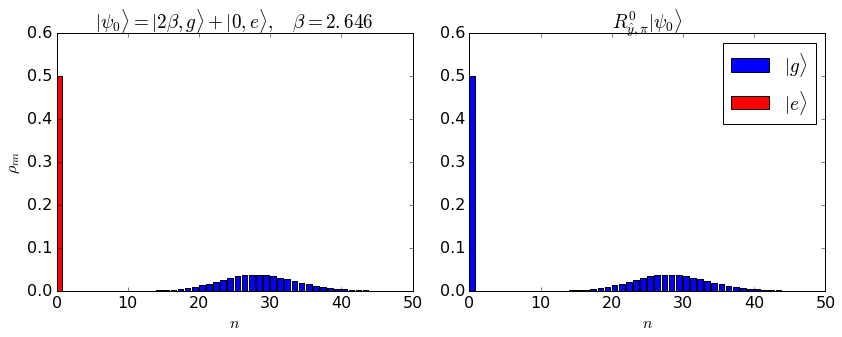

In [4]:
beta = np.sqrt(7)
# Initial state: |2beta, g> + |0, e>
psi0 = (qt.tensor(qt.coherent(Nmax, 2*beta), qt.basis(2, 1)) +
        qt.tensor(qt.basis(Nmax, 0), qt.basis(2, 0))).unit()
# Plot qubit population before conditional rotation
prob = qubitDistr(psi0)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.bar(np.arange(0, Nmax), prob[:, 0], color='b')
plt.bar(np.arange(0, Nmax), prob[:, 1], bottom=prob[:, 0], color='r')
plt.xlabel('$n$')
plt.ylabel(r'$\rho_{nn}$')
plt.title(r'$|\psi_0\rangle=|2\beta,g\rangle+|0,e\rangle,\quad\beta=%.3f$' % beta)
# Plot qubit population after conditional rotation
sigma = 5/(4*np.abs(beta)**2*chiQS)
rho = applyGaus(psi0, np.sqrt(np.pi/8)/sigma, sigma) # Amplitude for pi rotation is sqrt(pi/8)/sigma
prob = qubitDistr(rho)
plt.subplot(122)
plt.bar(np.arange(0, Nmax), prob[:, 0], color='b')
plt.bar(np.arange(0, Nmax), prob[:, 1], bottom=prob[:, 0], color='r')
plt.xlabel('$n$')
plt.title(r'$R_{\hat{y}, \pi}^0|\psi_0\rangle$')
plt.legend([r'$|g\rangle$', r'$|e\rangle$'])
plt.tight_layout()
plt.show()

Only the qubit state at $n=0$ is rotated and the $|2\beta, g\rangle$ part is not changed.

## Unconditional qubit rotation
An unconditional $\pi/2$ qubit rotation can be implemented by a rectangular qubit drive pulse with duration of 4 ns (see page 6 in Supplementary material of ref. 1).

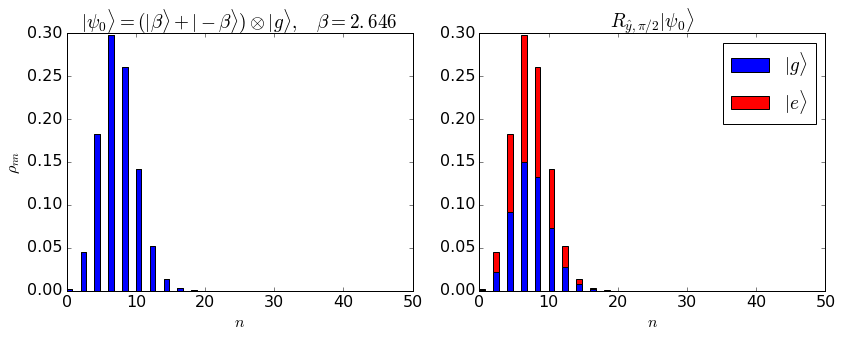

In [5]:
beta = np.sqrt(7)
# Initial state: (|beta> + |-beta>)|g>
psi0 = qt.tensor(qt.coherent(Nmax, beta) + qt.coherent(Nmax, -beta),
                 qt.basis(2, 1)).unit()
# Plot qubit population before unconditional rotation
prob = qubitDistr(psi0)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.bar(np.arange(0, Nmax), prob[:, 0], color='b')
plt.bar(np.arange(0, Nmax), prob[:, 1], bottom=prob[:, 0], color='r')
plt.xlabel('$n$')
plt.ylabel(r'$\rho_{nn}$')
plt.title(r'$|\psi_0\rangle=(|\beta\rangle+|-\beta\rangle)\otimes|g\rangle,\quad\beta=%.3f$' % beta)
# Plot qubit population after unconditional rotation
duration = 4e-9
rho = applyRect(psi0, np.pi/(4*duration), duration)  # Amplitude for pi/2 rotation is pi/4/duration
prob = qubitDistr(rho)
plt.subplot(122)
plt.bar(np.arange(0, Nmax), prob[:, 0], color='b')
plt.bar(np.arange(0, Nmax), prob[:, 1], bottom=prob[:, 0], color='r')
plt.xlabel('$n$')
plt.title(r'$R_{\hat{y}, \pi/2}|\psi_0\rangle$')
plt.legend([r'$|g\rangle$', r'$|e\rangle$'])
plt.tight_layout()
plt.show()

The $\pi/2$ rotation is applied to all photon number subspaces.

## Generating cat state
The qubit-photon system can be described by the dispersive Hamiltonian [eqn. (1) in ref. 1]:
$$H/\hbar = \omega_q|e\rangle\langle e|+\omega_s a^\dagger a-\chi_{qs}a^\dagger a|e\rangle\langle e|$$
Therefore, if we prepare the system in an initial state
$$|\Psi_0\rangle=|\alpha\rangle\otimes(|g\rangle+|e\rangle),$$
after time $\tau$ the final state becomes (disregarding free evolution caused by $\omega_q|e\rangle\langle e|+\omega_s a^\dagger a$)
$$|\Psi(\tau)\rangle=\exp(-\text{i}H\tau/\hbar)|\Psi_0\rangle=|\alpha\rangle\otimes|g\rangle+|\alpha\exp(\text{i}\chi_{qs}\tau)\rangle\otimes|e\rangle.$$
In particular, when $\chi_{qs}\tau=\pi$, $|\Psi(\tau)\rangle=|\alpha\rangle\otimes|g\rangle+|-\alpha\rangle\otimes|e\rangle$.

Combined with photon displacement operation, we can prepare a cat state using the following procedure [see fig. 1(B) in ref. 1]:  
1. Prepare unentagled qubit-cavity state $|\Psi_0\rangle = |\beta\rangle\otimes(|g\rangle+|e\rangle)$, using qubit rotation and cavity displacement.
2. Wait for $\tau=\pi/\chi_{qs}$ to evolve the state to $|\Psi_1\rangle=|\beta,g\rangle+|-\beta, e\rangle$.
3. Apply unconditional cavity displacement $D_\beta$ so that $|\Psi_2\rangle=D_\beta|\Psi_1\rangle=|2\beta, g\rangle+|0, e\rangle$.
4. Apply conditional qubit rotation $R_{\hat{y},\pi}^0$ so that $|\Psi_3\rangle=R_{\hat{y},\pi}^0|\Psi_2\rangle=(|2\beta\rangle+|0\rangle)\otimes|g\rangle$.
5. Apply unconditional cavity displacement $D_{-\beta}$ so that $|\Psi_4\rangle=D_{-\beta}|\Psi_3\rangle=(|\beta\rangle+|-\beta\rangle)\otimes|g\rangle$.

In [6]:
beta = np.sqrt(7)
psiv = qt.tensor(qt.basis(Nmax, 0), qt.basis(2, 1))
sigmaQ = 5/(4*np.abs(beta)**2*chiQS)
rectQ = 4e-9
rectC = 6e-9
# Step 1: Prepare initial state |beta>(|g>+|e>)
print('Unconditional qubit rotation by pi/2 ... ', end='')
rho0 = applyRect(psiv, np.pi/4/rectQ, rectQ)
print('Finished.\nCavity displacement by beta ... ', end='')
rho0 = driveCavity(rho0, beta/rectC, rectC)
# Step 2: Evolve for pi/chi
print('Finished.\nEvolve by pi/chi ... ', end='')
rho1 = evolve(rho0, np.pi/chiQS)
# Step 3: Apply cavity displacement D(beta)
print('Finished.\nCavity displacement by beta ... ', end='')
rho2 = driveCavity(rho1, beta/rectC, rectC)
# Step 4: Appy qubit pi rotation conditioned on zero photon
print('Finished.\nConditional qubit rotation by pi ... ', end='')
rho3 = applyGaus(rho2, np.sqrt(np.pi/8)/sigmaQ, sigmaQ)
# Step 5: Appy cavity displacement D(-beta)
print('Finished.\nCavity displacement by -beta ... ', end='')
rho4 = driveCavity(rho3, -beta/rectC, rectC)
print('Finished.')

Unconditional qubit rotation by pi/2 ... Finished.
Cavity displacement by beta ... Finished.
Evolve by pi/chi ... Finished.
Cavity displacement by beta ... Finished.
Conditional qubit rotation by pi ... Finished.
Cavity displacement by -beta ... Finished.


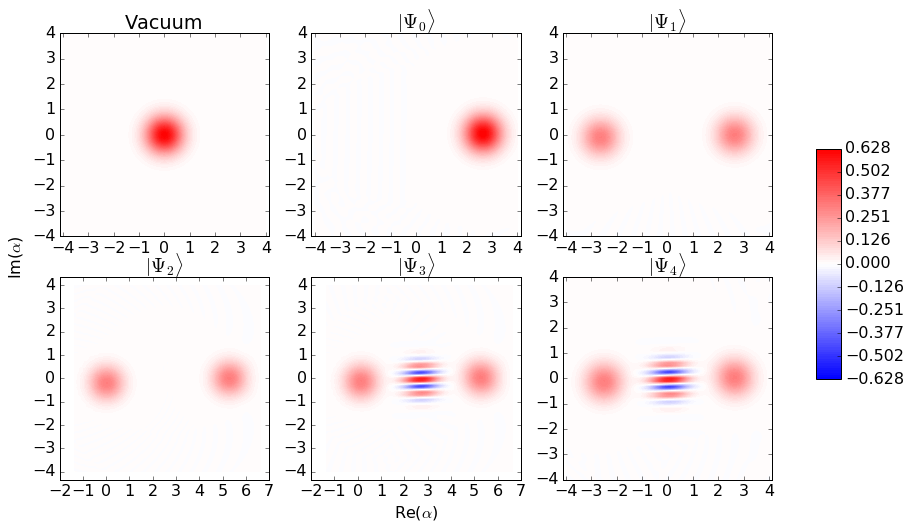

In [7]:
# Plot Wigner function after each step
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

fig.add_subplot(231)
areal = np.linspace(-4, 4, 81)
aimag = np.linspace(-4, 4, 81)
W = qt.wigner(qt.ptrace(psiv, 0), areal, aimag, g=2)
vrange = np.linspace(-np.max(np.max(W)), np.max(np.max(W)), 101)
plt.contourf(areal, aimag, W, vrange, cmap='bwr')
plt.axis('equal')
plt.title('Vacuum')

fig.add_subplot(232)
areal = np.linspace(-4, 4, 81)
aimag = np.linspace(-4, 4, 81)
W = qt.wigner(qt.ptrace(rho0, 0), areal, aimag, g=2)
vrange = np.linspace(-np.max(np.max(W)), np.max(np.max(W)), 101)
plt.contourf(areal, aimag, W, vrange, cmap='bwr')
plt.axis('equal')
plt.title(r'$|\Psi_0\rangle$')

fig.add_subplot(233)
areal = np.linspace(-4, 4, 81)
aimag = np.linspace(-4, 4, 81)
W = qt.wigner(qt.ptrace(rho1, 0), areal, aimag, g=2)
plt.contourf(areal, aimag, W, vrange, cmap='bwr')
plt.axis('equal')
plt.title(r'$|\Psi_1\rangle$')

fig.add_subplot(234)
areal = np.linspace(-4+np.sqrt(7), 4+np.sqrt(7), 81)
aimag = np.linspace(-4, 4, 81)
W = qt.wigner(qt.ptrace(rho2, 0), areal, aimag, g=2)
plt.contourf(areal, aimag, W, vrange, cmap='bwr')
plt.axis('equal')
plt.title(r'$|\Psi_2\rangle$')

fig.add_subplot(235)
areal = np.linspace(-4+np.sqrt(7), 4+np.sqrt(7), 81)
aimag = np.linspace(-4, 4, 81)
W = qt.wigner(qt.ptrace(rho3, 0), areal, aimag, g=2)
plt.contourf(areal, aimag, W, vrange, cmap='bwr')
plt.axis('equal')
plt.title(r'$|\Psi_3\rangle$')

fig.add_subplot(236)
areal = np.linspace(-4, 4, 81)
aimag = np.linspace(-4, 4, 81)
W = qt.wigner(qt.ptrace(rho4, 0), areal, aimag, g=2)
img = plt.contourf(areal, aimag, W, vrange, cmap='bwr')
plt.axis('equal')
plt.title(r'$|\Psi_4\rangle$')

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel(r'Re($\alpha$)')
ax.set_ylabel(r'Im($\alpha$)')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([1.0, 0.3, 0.03, 0.4])
fig.colorbar(img, cax=cbar_ax, ticks=np.linspace(vrange[0], vrange[-1], 11))

plt.show()

The photon state in each step is obtained by partial trace on qubit subspace: $\rho_s=\text{Tr}_{q}\rho$. For vacuum state and $|\Psi_0\rangle$, qubit and photons are unentangled, so the Wigner functions show pure coherent states; For $|\Psi_1\rangle$ and $|\Psi_2\rangle$, qubit and photons are maximally entangled, so the Wigner functions show a mixture of two coherent states (no interference fringes or negative values); For $|\Psi_3\rangle$ and $|\Psi_4\rangle$, qubit and photons are unentangled and cavity is in a cat state, so Wigner functions show the signature of non-classical states.

## Photon parity measurement
Because $\left.\exp(−i H\tau/\hbar)\right|_{\tau=\pi/\chi_{qs}}=\mathbb{1}\otimes|g\rangle\langle g|+\text{e}^{\text{i}\pi a^\dagger a}\otimes|e\rangle\langle e|$, photon parity operator $P=\text{e}^{\text{i}\pi a^\dagger a}$ can be measured by Ramsey interferometry. To save computation we use operators instead of applying pulses and time evolution to define the parity measurement.

In [8]:
# pi/2 rotation on qubit
X90 = qt.tensor(qt.qeye(Nmax), qt.rx(np.pi/2))
X90dag = X90.dag()
# Conditional cavit pi phase shift
C180 = qt.propagator(H=H0, t=np.pi/chiQS, c_op_list=[])
C180dag = C180.dag()
def parity(rho):
    # Parity measurement is pi/2 gate + C_pi gate + pi/2 gate followed by sigmaz measurement
    return np.real(qt.expect(sz, X90*C180*X90*rho*X90dag*C180dag*X90dag))
# Test on even and odd parity states
alpha = 2
psi1 = qt.tensor(qt.coherent(Nmax, alpha) + qt.coherent(Nmax, -alpha), qt.basis(2, 1)).unit()
psi2 = qt.tensor(qt.coherent(Nmax, 1j*alpha) - qt.coherent(Nmax, -1j*alpha), qt.basis(2, 1)).unit()
display(Markdown(r'Parity of $|C_\alpha^+\rangle=|\alpha\rangle+|-\alpha\rangle$ is %f' % parity(psi1*psi1.dag())))
display(Markdown(r'Parity of $|C_{i\alpha}^-\rangle=|i\alpha\rangle-|-i\alpha\rangle$ is %f' % parity(psi2*psi2.dag())))

Parity of $|C_\alpha^+\rangle=|\alpha\rangle+|-\alpha\rangle$ is 1.000000

Parity of $|C_{i\alpha}^-\rangle=|i\alpha\rangle-|-i\alpha\rangle$ is -1.000000

## Wigner tomography
The Wigner function of a photon state $\rho$ is defined by [eqn. (S6) in ref. 1]
$$W(\alpha)=\frac{2}{\pi}\text{Tr}[D_\alpha^\dagger\rho D_\alpha P],$$
where $D_\alpha=\text{e}^{\alpha a^\dagger-\alpha^* a}$ is the displacement operator, and $P=\text{e}^{\text{i}\pi a^\dagger a}$ is the parity operator. In other words, the Wigner function can be obtained by first displacing the photon state and then measuring the expectation value of the parity operator. Experimentally, displacement can be implemented by applying coherent drive pulse to the cavity, and parity measurement is discussed above.

10.0%. Run time:   3.44s. Est. time left: 00:00:00:30
20.0%. Run time:   6.53s. Est. time left: 00:00:00:26
30.0%. Run time:   9.64s. Est. time left: 00:00:00:22
40.0%. Run time:  13.54s. Est. time left: 00:00:00:20
50.0%. Run time:  17.33s. Est. time left: 00:00:00:17
60.0%. Run time:  20.64s. Est. time left: 00:00:00:13
70.0%. Run time:  23.69s. Est. time left: 00:00:00:10
80.0%. Run time:  26.76s. Est. time left: 00:00:00:06
90.0%. Run time:  29.86s. Est. time left: 00:00:00:03
100.0%. Run time:  32.94s. Est. time left: 00:00:00:00
Total run time:  32.98s


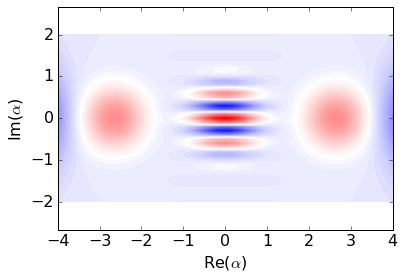

In [9]:
def wigner(alpha, rho):
    # Wigner function is displacement + parity measurement
    D = qt.tensor(qt.displace(Nmax, alpha), qt.qeye(2))
    return 2/np.pi*parity(D.dag()*rho*D)

# Test on cat state
beta = np.sqrt(7)
psi = qt.tensor(qt.coherent(Nmax, beta) + qt.coherent(Nmax, -beta), qt.basis(2, 1)).unit()
rho = psi*psi.dag()

areal = np.linspace(-4, 4, 81)
aimag = np.linspace(-2, 2, 41)
alpha = [x + 1j*y for y in aimag for x in areal]
        
W = qt.parallel_map(wigner, alpha, task_args=(rho,), progress_bar=True)
W = np.array(W).reshape((len(aimag), len(areal)))

plt.figure()
plt.contourf(areal, aimag, W, 100, cmap='bwr')
plt.xlabel(r'Re($\alpha$)')
plt.ylabel(r'Im($\alpha$)')
plt.axis('equal')
plt.show()

## Tracking photon jumps with repeated parity measurements
With long photon lifetime and the ability to do single shot qubit readout, it is possible to monitor photon jumps continuously, which is necessary for error correction in cat codes. See ref. 2 for details.

In [10]:
# Initial state: photons in even parity cat state |alpha>+|-alpha>, qubit in |g>+|e>
alpha = 2
psi0 = qt.tensor(qt.coherent(Nmax, alpha)+qt.coherent(Nmax, -alpha),
                 qt.basis(2, 1) + qt.basis(2, 0)).unit()
# Monitor a single quantum trajectory with time step pi/chi
tlist = np.arange(0, 1e-3, np.pi/chiQS)
print('Running Monte Carlo solver ... ', end='')
result = qt.mcsolve(H=H0, psi0=psi0, tlist=tlist, c_ops=[np.sqrt(kappaS)*a],
                    e_ops=[], ntraj=1, options=qt.Options(seeds=[23]),
                    progress_bar=False)
print('Finished.')

Running Monte Carlo solver ... Finished.


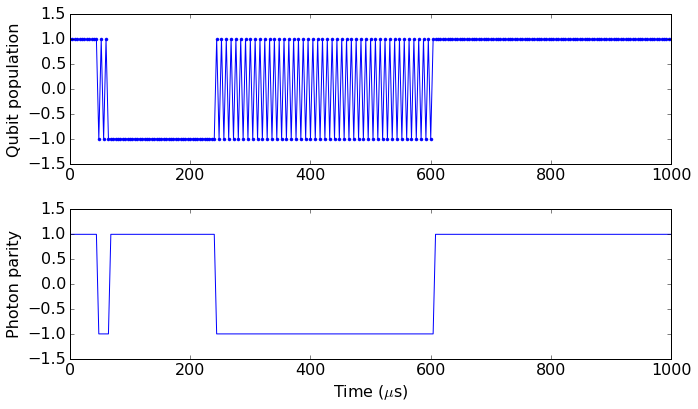

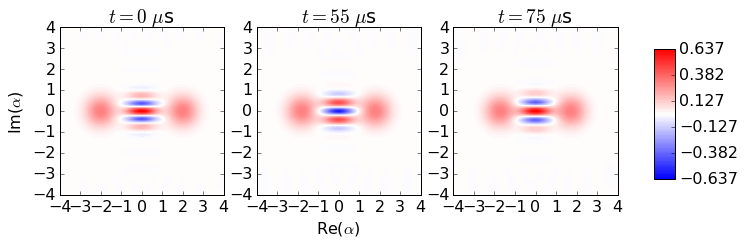

In [11]:
# Calculator expection value of sigmax, sigmay and photon parity at each time step
psilist = result.states[0]
sxlist = np.real(qt.expect(sx, psilist))
sylist = np.real(qt.expect(sy, psilist))
plist = np.real(qt.expect((1j*np.pi*adag*a).expm(), psilist))
# Record the flip of sigmax+1j*sigmay
flip = np.zeros(len(tlist))
traj = np.zeros(len(tlist))
flip[0] = 1
flip[1:] = np.real((sxlist[1:]+1j*sylist[1:])/(sxlist[:-1]+1j*sylist[:-1]))
# Plot the trajectory for every 16 steps
step = 16
eps = 1e-6
traj[0] = sxlist[0]
for ii in np.arange(step, len(tlist), step):
    if np.abs(flip[ii]-1) < eps or np.abs(flip[ii]+1) < eps:
        traj[ii] = traj[ii-step]*flip[ii]
    else:
        traj[ii] = traj[ii-step]

plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(tlist[::step]/1e-6, traj[::step], '.-')
plt.xlim([0, 1000])
plt.ylim([-1.5, 1.5])
plt.ylabel('Qubit population')
plt.subplot(212)
plt.plot(tlist[::step]/1e-6, plist[::step])
plt.xlim([0, 1000])
plt.ylim([-1.5, 1.5])
plt.ylabel('Photon parity')
plt.xlabel(r'Time ($\mu$s)')
plt.tight_layout()
plt.show()
# Plot wigner function 
tplot = np.array([0, 55, 75])*1e-6
nplot = len(tplot)
areal = np.linspace(-4, 4, 81)
aimag = np.linspace(-4, 4, 81)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
for ii in range(0, nplot):
    index = np.argmin(np.abs(tlist-tplot[ii]))
    psi = psilist[index]
    W = qt.wigner(qt.ptrace(psi, 0), areal, aimag, g=2)
    fig.add_subplot(1, nplot, ii+1)
    if ii == 0:
        vrange = np.linspace(-np.max(np.max(W)), np.max(np.max(W)), 101)
        img = plt.contourf(areal, aimag, W, vrange, cmap='bwr')
    else:
        plt.contourf(areal, aimag, W, vrange, cmap='bwr')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.title(r'$t=%.0f\ \mu$s' % (tplot[ii]/1e-6))

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel(r'Re($\alpha$)')
ax.set_ylabel(r'Im($\alpha$)')
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
fig.colorbar(img, cax=cbar_ax, ticks=np.linspace(vrange[0], vrange[-1], 6))
plt.show()

A constant qubit population corresponds to even photon parity, and an oscillating qubit population corresponds to odd photon parity (see fig. 3 in ref. 2). In Wigner tomography, $W(0)=+/-\frac{2}{\pi}$ correspond to even/odd parity. Notice the change of color at origin when t = 55 $\mu$s. The size of the cat state also shinks slightly as it evolves, indicating the decay of the coherent states.

## Encoding/decoding cat code
This step requires pulse synthesis to implement unitary transformations to map between (see ref. 3)
$$(c_0|g\rangle+c_1|e\rangle)|0\rangle\leftrightarrow|g\rangle(c_0|C_\alpha^+\rangle+c_1|C_{i\alpha}^+\rangle),$$
and needs to be done by numerical optimization methods such as GRAPE.

In [12]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,3.2.0.dev-88e1862
Numpy,1.11.1
SciPy,0.18.0
matplotlib,1.5.1
Cython,0.24.1
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,5.1.0
Python,"3.5.2 |Continuum Analytics, Inc.| (default, Jul 2 2016, 17:53:06) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
